# Germany vs USA Cookie Consent Analysis
A comparative analysis of cookie consent interfaces and tracking behaviors between German and USA web traffic.

**Data Source:** [Consent Observatory](https://consentobservatory.org/) scraper.
* **Germany**: Nuremberg, Bayern
* **USA**: Salt Lake City, Utah

**Reference**: *Nouwens et al., CHI '25 - A Cross-Country Analysis of GDPR Cookie Banners.*

---
### Notebook Overview:
1. **Setup & Data Loading**: Environment configuration and ingestion of raw regional data.
2. **Data Preprocessing & Scope**: Scraping yield, error handling, and applying the common-site filter.
3. **Cookie Volume & Distribution**: Comparative analysis of cookie-dropping behavior.
4. **Consent Interface Prevalence**: Analysis of cookie banner presence across regions.
5. **Button Category & Prominence Analysis**: Deduplication and categorization of consent options (Accept, Reject, Settings, etc.).


## 1. Setup
Importing necessary libraries, defining global variables (such as file paths and plot styling), and setting up regional color palettes for consistency across visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.legend_handler import HandlerTuple
import matplotlib.patches as mpatches
from pathlib import Path
import json

# this is where we are getting the extracted data for Germany and USA
OUTPUT_DIR = Path('../data/output')
EXAMPLES_DIR = Path('../data/examples')

# setup for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (9, 4.5),
    'figure.dpi': 130,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# red for Germany, blue for USA
COLORS = {'Germany': '#DD0000', 'USA': '#00205B'}
# button categories for cookie banners
BUTTON_CATEGORIES = {1: 'Accept', 2: 'Reject', 3: 'Settings', 4: 'Save', 5: 'Other'}

print("Setup complete.")


Setup complete.


## 2. Data Loading


We load the JSON files and check how many URLs were successfully scraped in each.

In [2]:
def load_records_from_json_file(json_path):
    records = []
    with open(json_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                records.append(json.loads(line))
    return records

all_de_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco-germany.json')
all_us_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco-us.json')

print(f"All Germany records: {len(all_de_records)}")
print(f"All USA records: {len(all_us_records)}")

All Germany records: 741
All USA records: 770


* We load the CSV files extracted from the raw JSON by `extract_data.py`, one CSV per data type (cookies, buttons, CMPs, errors) per region.
* Each row represents a single extracted item (e.g., one cookie, one button element).

In [ ]:
# these are the CSV files we extracted from the JSON files using extract_data.py
# load cookie data
df_cookies_de = pd.read_csv(OUTPUT_DIR / 'cookies_germany.csv')
df_cookies_us = pd.read_csv(OUTPUT_DIR / 'cookies_us.csv')

# load button data
df_buttons_de = pd.read_csv(OUTPUT_DIR / 'buttons_germany.csv')
df_buttons_us = pd.read_csv(OUTPUT_DIR / 'buttons_us.csv')

# load CMP data
df_cmp_de = pd.read_csv(OUTPUT_DIR / 'cmps_germany.csv')
df_cmp_us = pd.read_csv(OUTPUT_DIR / 'cmps_us.csv')

# load error logs
df_errors_de = pd.read_csv(OUTPUT_DIR / 'errors_germany.csv')
df_errors_us = pd.read_csv(OUTPUT_DIR / 'errors_us.csv')

print("Raw row counts: every row is one extracted data item (cookie, button, CMP)")
print(f"  - Cookies  -->    Germany: {len(df_cookies_de):>6,}    USA: {len(df_cookies_us):,}")
print(f"  - Buttons  -->    Germany: {len(df_buttons_de):>6,}    USA: {len(df_buttons_us):,}")
print(f"  - CMPs     -->    Germany: {len(df_cmp_de):>6,}    USA: {len(df_cmp_us):,}")
print(f"  - Errors   -->    Germany: {len(df_errors_de):>6,}    USA: {len(df_errors_us):,}")


Raw row counts: every row is one extracted data item (cookie, button, CMP)
  - Cookies  -->    Germany:  9,352    USA: 797
  - CMPs     -->    Germany: 17,069    USA: 8,568
  - Errors   -->    Germany:    259    USA: 230


## 3. Data Preprocessing

### 3.1 Scraping Failures

Not every URL is reachable. Sites may time out, block the scraper, or be unavailable.
Understanding *how many* URLs failed and *what kind* of errors occurred (and whether
that differs between Germany and USA) matters for assessing how representative our
analysis is.


In [4]:
print("Scraping failure counts:")
print(f"  Germany : {len(df_errors_de)} failed URLs")
print(f"  USA     : {len(df_errors_us)} failed URLs")


Scraping failure counts:
  Germany : 259 failed URLs
  USA     : 230 failed URLs


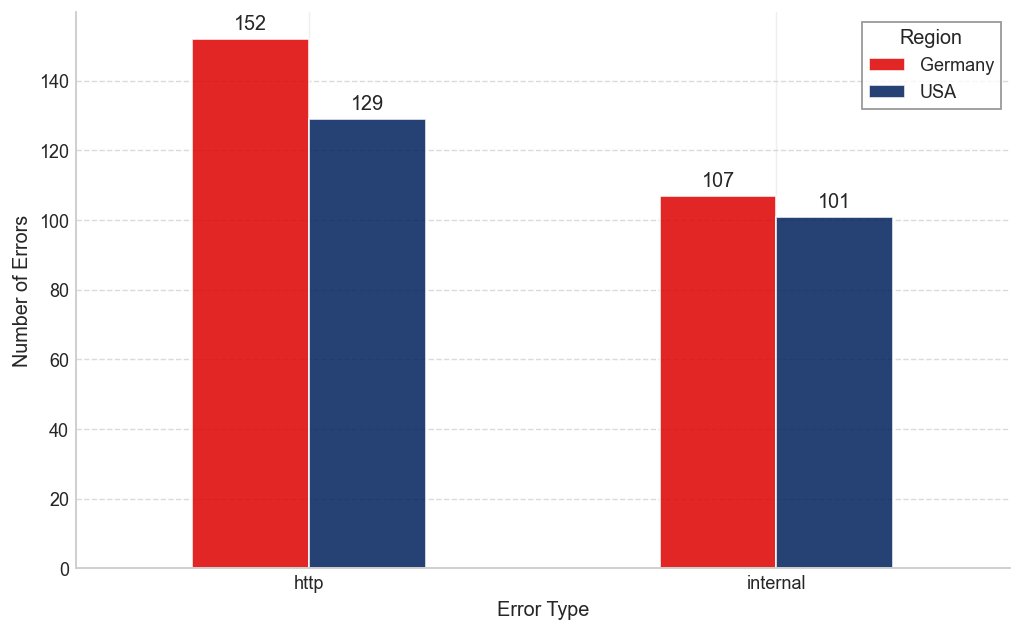

In [5]:
# count the error types for both regions
de_errors = df_errors_de['error_type'].value_counts()
us_errors = df_errors_us['error_type'].value_counts()

# combine into a single DataFrame for easy plotting
df_errors_combined = pd.DataFrame({
    'Germany': de_errors,
    'USA': us_errors
})

# create the grouped bar plot
fig, ax = plt.subplots(figsize=(8, 5))

# plotting directly with Pandas, makes grouped bars automatically
df_errors_combined.plot(
    kind='bar', 
    ax=ax, 
    color=[COLORS.get("Germany", "#1f77b4"), COLORS.get("USA", "#ff7f0e")], 
    edgecolor='white',
    alpha=0.85
)

for container in ax.containers:
    ax.bar_label(container, padding=3)

# formatting the plot
# ax.set_title('Error Types Comparison')
ax.set_xlabel('Error Type')
ax.set_ylabel('Number of Errors')
plt.xticks(rotation=0) # Keeps the 'http' and 'internal' labels horizontal
ax.legend(title='Region', frameon=True, fancybox=False, edgecolor='gray')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### 3.2 Find Common Websites and Filter the Datasets

To ensure an unbiased comparison, we decided that we must restrict our analysis to websites that were successfully reached by the scraper in **both** countries.

**Methodology**:
- We compute the intersection of URLs scraped in both the US and Germany datasets (`common_urls`).
- Every subsequent dataframe is filtered to this set.
- If a site was visited in both regions but lacks cookie/banner data in one, we treat it as having "0 cookies" or "no banner" rather than dropping it.

In [6]:
# find common websites and filter
de_urls = {r.get('url') for r in all_de_records}
us_urls = {r.get('url') for r in all_us_records}
common_urls = de_urls & us_urls

# filter JSONs for common URLs
de_records = [r for r in all_de_records if r.get('url') in common_urls]
us_records = [r for r in all_us_records if r.get('url') in common_urls]


print("Dataset Change after filtering for common URLs:")
print(f"  - Germany  -->    Before: {len(all_de_records):>6}    After: {len(de_records):>6}   Dropped: {len(all_de_records) - len(de_records):}")
print(f"  - USA      -->    Before: {len(all_us_records):>6}    After: {len(us_records):>6}   Dropped: {len(all_us_records) - len(us_records):}")

Dataset Change after filtering for common URLs:
  - Germany  -->    Before:    741    After:    705   Dropped: 36
  - USA      -->    Before:    770    After:    705   Dropped: 65


In [7]:
# apply the common-site filter to EVERY dataframe
# Sites absent from one region's CSV are not dropped from the analysis
df_cookies_de = df_cookies_de[df_cookies_de['website_url'].isin(common_urls)]
df_cookies_us = df_cookies_us[df_cookies_us['website_url'].isin(common_urls)]

df_buttons_de = df_buttons_de[df_buttons_de['website_url'].isin(common_urls)]
df_buttons_us = df_buttons_us[df_buttons_us['website_url'].isin(common_urls)]

df_cmp_de = df_cmp_de[df_cmp_de['website_url'].isin(common_urls)]
df_cmp_us = df_cmp_us[df_cmp_us['website_url'].isin(common_urls)]

print("Row counts after common-site filter:")
print(f"  - Cookies  --> Germany: {len(df_cookies_de):>6,}   USA: {len(df_cookies_us):,}")
print(f"  - Buttons  --> Germany: {len(df_buttons_de):>6,}   USA: {len(df_buttons_us):,}")
print(f"  - CMPs     --> Germany: {len(df_cmp_de):>6,}   USA: {len(df_cmp_us):,}")


Row counts after common-site filter:
  - Cookies  --> Germany:  8,442   USA: 24,541
  - Buttons  --> Germany: 15,205   USA: 747
  - CMPs     --> Germany: 10,498   USA: 8,401


### 3.3 Deduplicate Buttons CSV File

Buttons are classified into five core categories: **Accept (1), Reject (2), Settings (3), Save (4), and Other (5)**.

A single site may contain multiple HTML elements mapping to the same conceptual category (e.g., two "Accept" buttons). Mirroring the methodology of Nouwens et al., we retain only the button with the highest calculated ***visibility score*** per `(website_url, category)` pair.

In [8]:
def clean_buttons(df):
    """Keep the single most-visible button per (site, category)."""
    df = df.copy()
    df['vis_score'] = pd.to_numeric(df['vis_score'], errors='coerce')
    # Sort so the best (highest) score comes first for each group
    df = df.sort_values(
        ['website_url', 'category', 'vis_score'],
        ascending=[True, True, False]
    )
    # One row per (site, category) -- the most visible button wins
    return df.drop_duplicates(subset=['website_url', 'category'], keep='first')

df_buttons_de = clean_buttons(df_buttons_de)
df_buttons_us = clean_buttons(df_buttons_us)

print("Row counts after cleaning repeated buttons:")
print(f"  - Buttons  --> Germany: {len(df_buttons_de):>6,}   USA: {len(df_buttons_us):,}")

Row counts after cleaning repeated buttons:
  - Buttons  --> Germany:    957   USA: 522


## 4. Cookies Analysis

We count all cookies observed per site and compare distributions between Germany and the USA.

### 4.1 Cookie Distribution per Website
How are cookies distributed across websites in each region?

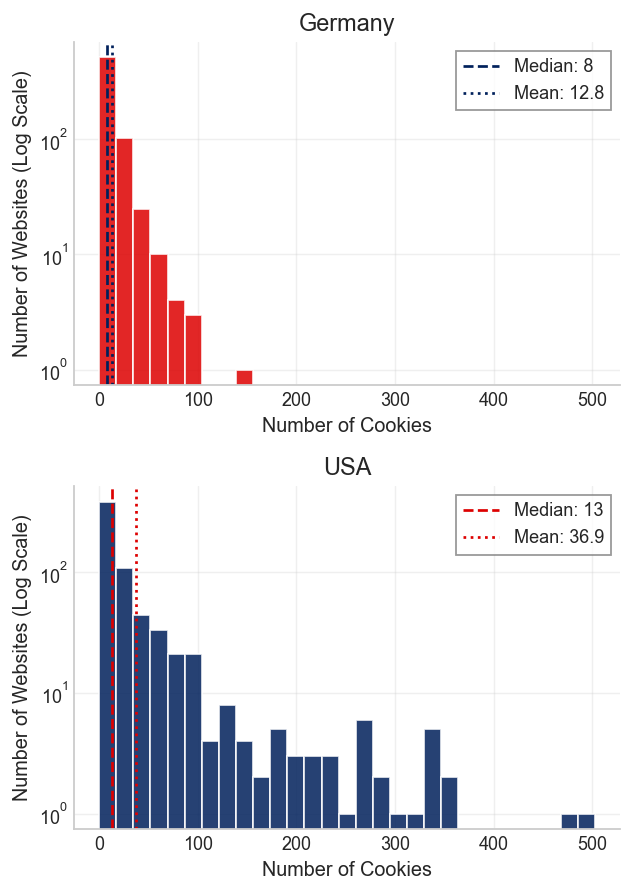

Germany - Mean: 12.81, Median: 8, Max: 143
USA - Mean: 36.90, Median: 13, Max: 503


In [9]:
# cookies per website distribution
de_cookies_per_site = df_cookies_de.groupby('website_url').size()
us_cookies_per_site = df_cookies_us.groupby('website_url').size()

# calculate common bins so bar widths match
# find the max cookies 
global_max = max(de_cookies_per_site.max(), us_cookies_per_site.max())
common_bins = np.linspace(0, global_max, 30)

fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# Germany histogram (log=True makes the y-axis logarithmic)
axes[0].hist(de_cookies_per_site, bins=common_bins, color=COLORS["Germany"], edgecolor='white', alpha=0.85, log=True)
axes[0].set_xlabel('Number of Cookies')
axes[0].set_ylabel('Number of Websites (Log Scale)')
axes[0].set_title('Germany')
# Swapped to USA color for the lines
axes[0].axvline(de_cookies_per_site.median(), color=COLORS["USA"], linestyle='--', linewidth=1.5, label=f'Median: {de_cookies_per_site.median():.0f}')
axes[0].axvline(de_cookies_per_site.mean(), color=COLORS["USA"], linestyle=':', linewidth=1.5, label=f'Mean: {de_cookies_per_site.mean():.1f}')
axes[0].legend(frameon=True, fancybox=False, edgecolor='gray')

# USA histogram (log=True applied here as well)
axes[1].hist(us_cookies_per_site, bins=common_bins, color=COLORS["USA"], edgecolor='white', alpha=0.85, log=True)
axes[1].set_xlabel('Number of Cookies')
axes[1].set_ylabel('Number of Websites (Log Scale)') 
axes[1].set_title('USA')
# Swapped to Germany color for the lines
axes[1].axvline(us_cookies_per_site.median(), color=COLORS["Germany"], linestyle='--', linewidth=1.5, label=f'Median: {us_cookies_per_site.median():.0f}')
axes[1].axvline(us_cookies_per_site.mean(), color=COLORS["Germany"], linestyle=':', linewidth=1.5, label=f'Mean: {us_cookies_per_site.mean():.1f}')
axes[1].legend(frameon=True, fancybox=False, edgecolor='gray')

plt.tight_layout()
plt.show()

# summary stats
print(f"Germany - Mean: {de_cookies_per_site.mean():.2f}, Median: {de_cookies_per_site.median():.0f}, Max: {de_cookies_per_site.max()}")
print(f"USA - Mean: {us_cookies_per_site.mean():.2f}, Median: {us_cookies_per_site.median():.0f}, Max: {us_cookies_per_site.max()}")

### 4.2 Which websites have the most cookies per region?

In [10]:
# Top-10 cookie-heaviest sites per region
de_top10 = de_cookies_per_site.sort_values(ascending=False).head(10).reset_index()
us_top10 = us_cookies_per_site.sort_values(ascending=False).head(10).reset_index()
de_top10.columns = ['Germany (site)', 'Cookies']
us_top10.columns = ['USA (site)', 'Cookies']
top10_table = pd.concat([de_top10, us_top10], axis=1)
top10_table.index = range(1, 11); top10_table.index.name = 'Rank'
print("Top-10 most cookie-heavy sites per region:")
display(top10_table)


Top-10 most cookie-heavy sites per region:


,Germany (site),Cookies,USA (site),Cookies
Rank,,,,
1,ficbook.net,143,time.com,503
2,macys.com,91,dantri.com.vn,472
3,lowes.com,91,genius.com,350
4,carsensor.net,89,britannica.com,350
5,alibaba.com,82,aol.com,346
6,rakuten.co.jp,73,huffpost.com,345
7,cmoa.jp,70,tycsports.com,341
8,hbr.org,70,speedtest.net,337
9,yandex.ru,67,mydramalist.com,335


### 4.2 Which websites have the most cookies per region?

In [11]:
# sites with the biggest regional difference
# an outer merge aligns both series on website_url, zeros fill the gaps
merged_cookies = pd.concat([de_cookies_per_site.rename('de'), us_cookies_per_site.rename('us')], axis=1).fillna(0)
merged_cookies['diff'] = (merged_cookies['de'] - merged_cookies['us']).astype(int)

de_more = merged_cookies[merged_cookies['diff'] > 0].sort_values('diff', ascending=False).head(10)[['diff']].reset_index()
us_more = merged_cookies[merged_cookies['diff'] < 0].sort_values('diff').head(10).assign(diff=lambda d: -d['diff'])[['diff']].reset_index()
de_more.columns = ['Germany Has More', 'Diff']
us_more.columns = ['USA Has More', 'Diff']

diff_table = pd.concat([de_more, us_more], axis=1)
diff_table.index = range(1, 11); diff_table.index.name = 'Rank'
print("Largest per-site cookie count differences:")
display(diff_table)


Largest per-site cookie count differences:


,Germany Has More,Diff,USA Has More,Diff
Rank,,,,
1,worldbank.org,29,dantri.com.vn,462
2,savefrom.net,20,time.com,444
3,ebay.com,19,aol.com,343
4,prnewswire.com,12,genius.com,339
5,furaffinity.net,12,britannica.com,338
6,jd.com,9,huffpost.com,334
7,cnn.com,9,tycsports.com,330
8,alibaba.com,9,speedtest.net,328
9,okxxx1.com,5,kooora.com,311


## 5. Consent Interface Presence

***Logic:*** a site ***has a consent banner*** if it appears in the (filtered) buttons CSV.
A site in `common_sites` that has no button rows is counted as ***no banner***.

So, if the scraper visited the site and found nothing, there was nothing to find.


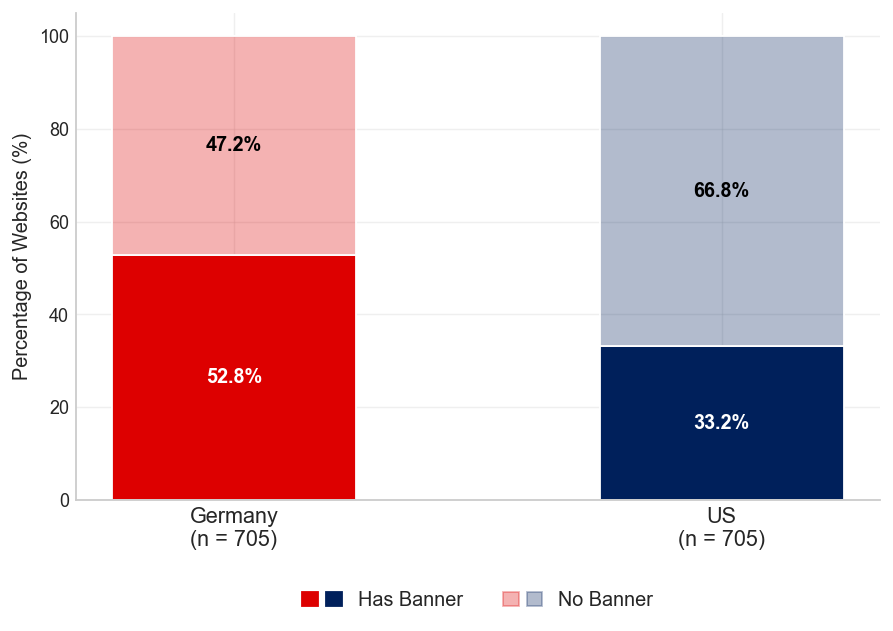

Germany: 372/705  (52.8%) have a banner
USA    : 234/705  (33.2%) have a banner
Gap    : 19.6 percentage points


In [12]:
# calculate the raw counts (for the text printout at the end)
de_count = df_buttons_de['website_url'].nunique()
us_count = df_buttons_us['website_url'].nunique()
total_common = len(common_urls)

# calculate percentages (for the chart)
de_with_pct = (de_count / total_common) * 100
us_with_pct = (us_count / total_common) * 100
de_no_pct   = 100 - de_with_pct
us_no_pct   = 100 - us_with_pct

# plot settings
fig, ax = plt.subplots(figsize=(7, 5))

countries = ['Germany', 'USA']
with_banner = [de_with_pct, us_with_pct]
no_banner = [de_no_pct, us_no_pct]
x_positions = [0, 1]
bar_width = 0.5

# build the stacked bars
for i, country in enumerate(countries):
    base_color = COLORS[country]
    lighter_color = to_rgba(base_color, alpha=0.3)
    
    # bottom bar: has banner (removed 'label' parameter)
    ax.bar(x_positions[i], with_banner[i], width=bar_width, color=base_color, edgecolor='white')
    
    # top bar: no banner (removed 'label' parameter)
    ax.bar(x_positions[i], no_banner[i], width=bar_width, bottom=with_banner[i], 
           color=lighter_color, edgecolor='white')
    
    # Label for Bottom Bar (Has Banner)
    ax.text(x_positions[i], with_banner[i] / 2, 
            f"{with_banner[i]:.1f}%", 
            ha='center', va='center', color='white', fontweight='bold')

    # Label for Top Bar (No Banner)
    ax.text(x_positions[i], with_banner[i] + (no_banner[i] / 2), 
            f"{no_banner[i]:.1f}%", 
            ha='center', va='center', color='black', fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels([f'Germany\n(n = {total_common:,})', f'US\n(n = {total_common:,})'], fontsize=12)
ax.set_ylabel('Percentage of Websites (%)', fontsize=11)

# Define the base and light colors
de_base = COLORS['Germany']
us_base = COLORS['USA']
de_light = to_rgba(de_base, alpha=0.3)
us_light = to_rgba(us_base, alpha=0.3)

# Create the patch objects
patch_has_de = mpatches.Patch(color=de_base)
patch_has_us = mpatches.Patch(color=us_base)
patch_no_de  = mpatches.Patch(color=de_light)
patch_no_us  = mpatches.Patch(color=us_light)

# Create the legend using HandlerTuple to combine the patches side-by-side
ax.legend(
    [(patch_has_de, patch_has_us), (patch_no_de, patch_no_us)], # Group them as tuples
    ['Has Banner', 'No Banner'],                                # The two labels
    handler_map={tuple: HandlerTuple(ndivide=None)},            # Tell Matplotlib to put tuples side-by-side
    loc='upper center', bbox_to_anchor=(0.5, -0.15),            # Position below chart
    ncol=2, frameon=False, fontsize=11
)

plt.tight_layout()
plt.show()

# Print the text summary using correct counts
print(f"Germany: {de_count:,}/{total_common:,}  ({de_with_pct:.1f}%) have a banner")
print(f"USA    : {us_count:,}/{total_common:,}  ({us_with_pct:.1f}%) have a banner")
print(f"Gap    : {abs(de_with_pct - us_with_pct):.1f} percentage points")

## 6. Button Category Analysis

We examine the five button categories found in consent banners: **Accept (1), Reject (2), Settings (3), Save (4), and Other (5)**. For each, we measure how often it appears and how its presence differs between regions.

### 6.1 Regional Shift in Button Prevalence
How does the presence of each button type differ between the two regions? The slope chart below connects each category's percentage in Germany to its percentage in the USA.

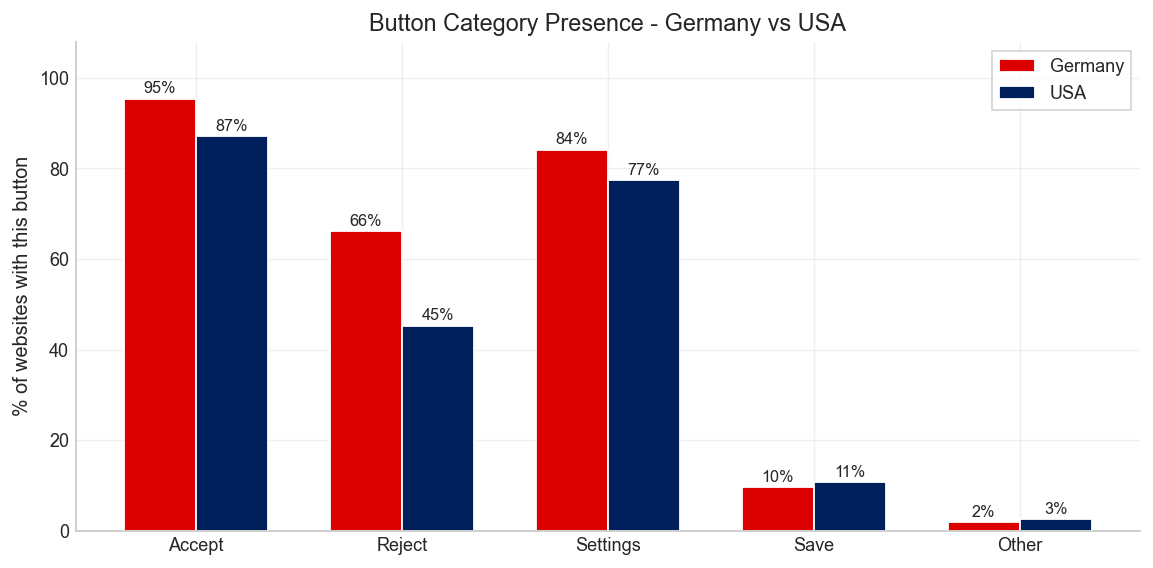

,Germany,USA
Accept,95.4,87.2
Reject,66.1,45.3
Settings,84.1,77.4
Save,9.7,10.7
Other,1.9,2.6


In [13]:
def button_existence(df):
    matrix = pd.crosstab(df['website_url'], df['category'])
    return (matrix > 0).astype(int)

de_exist = button_existence(df_buttons_de)
us_exist = button_existence(df_buttons_us)

# % of websites that have each button type
de_pct = (de_exist.mean() * 100).rename('Germany')
us_pct = (us_exist.mean() * 100).rename('USA')
btn_comp = pd.concat([de_pct, us_pct], axis=1).fillna(0)
btn_comp.index = [BUTTON_CATEGORIES.get(i, str(i)) for i in btn_comp.index]

# Grouped bar chart
x = np.arange(len(btn_comp))
w = 0.35
fig, ax = plt.subplots(figsize=(9, 4.5))
b_de = ax.bar(x - w/2, btn_comp['Germany'], w, label='Germany', color=COLORS['Germany'], edgecolor='white')
b_us = ax.bar(x + w/2, btn_comp['USA'],      w, label='USA',      color=COLORS['USA'],      edgecolor='white')
ax.set_xticks(x); ax.set_xticklabels(btn_comp.index)
ax.set_ylabel('% of websites with this button'); ax.set_ylim(0, 108)
ax.legend(frameon=True, fancybox=False)
ax.set_title('Button Category Presence - Germany vs USA')

for bars in [b_de, b_us]:
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.0f}%',
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', fontsize=9)
plt.tight_layout(); plt.show()
display(btn_comp.round(1))


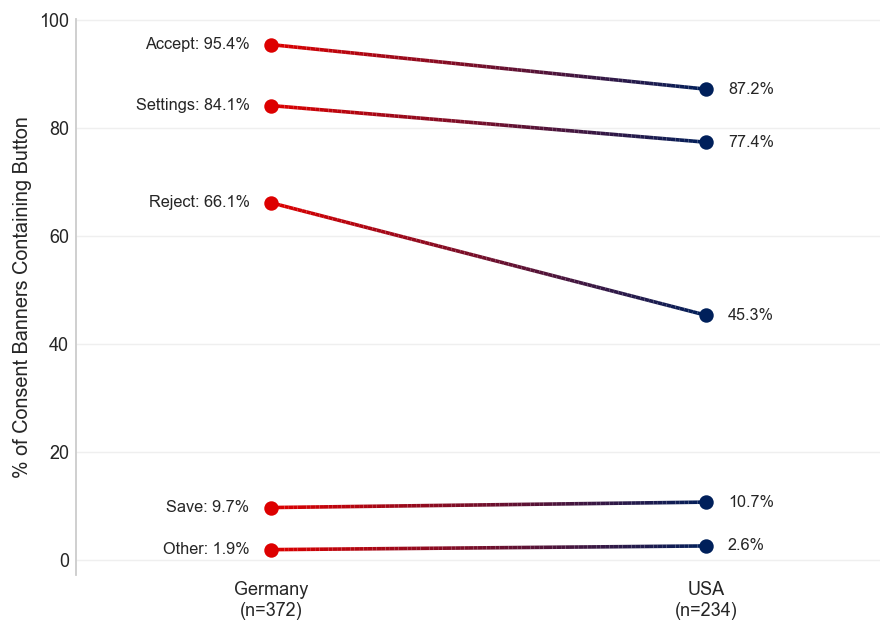

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))

# Create a custom color map that transitions smoothly from Germany's color to the US's color
gradient_cmap = LinearSegmentedColormap.from_list("DeUsGradient", [COLORS["Germany"], COLORS["USA"]])

for i, (cat_id, cat_name) in enumerate(BUTTON_CATEGORIES.items()):
    de_v = de_exist[cat_id].mean() * 100 if cat_id in de_exist.columns else 0
    us_v = us_exist[cat_id].mean() * 100 if cat_id in us_exist.columns else 0
    
    # 1. Generate 100 tiny points between the start and end values
    x = np.linspace(0, 1, 100)
    y = np.linspace(de_v, us_v, 100)
    
    # 2. Format these points into segments for Matplotlib
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # 3. Create the gradient line and add it to the plot
    lc = LineCollection(segments, cmap=gradient_cmap, norm=plt.Normalize(0, 1))
    lc.set_array(x) # This tells the gradient to progress along the x-axis
    lc.set_linewidth(2)
    ax.add_collection(lc)
    
    # 4. Draw the dots at the ends using the exact solid colors
    ax.plot(0, de_v, 'o', color=COLORS["Germany"], ms=7)
    ax.plot(1, us_v, 'o', color=COLORS["USA"], ms=7)
    
    # 5. Add the text labels
    ax.text(-0.05, de_v, f'{cat_name}: {de_v:.1f}%', ha='right', va='center', fontsize=9)
    ax.text( 1.05, us_v, f'{us_v:.1f}%',             ha='left',  va='center', fontsize=9)

ax.set_xlim(-0.45, 1.4)
ax.set_xticks([0, 1])
ax.set_xticklabels([f'Germany\n(n={len(de_exist)})', f'USA\n(n={len(us_exist)})'])

# --- UPDATED LABELS HERE ---
ax.set_ylabel('% of Consent Banners Containing Button')
# ax.set_title('Button Type Prevalence (Sites with Consent Banners Only)')

ax.spines['bottom'].set_visible(False)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

### 6.2 Visual Prominence — Accept vs. Reject

Even when both buttons exist, are they designed equally?
We compute `vis_score(Accept) − vis_score(Reject)` for every website that has both.
Positive values mean Accept has a higher visibility score, the paper considers this a dark pattern.

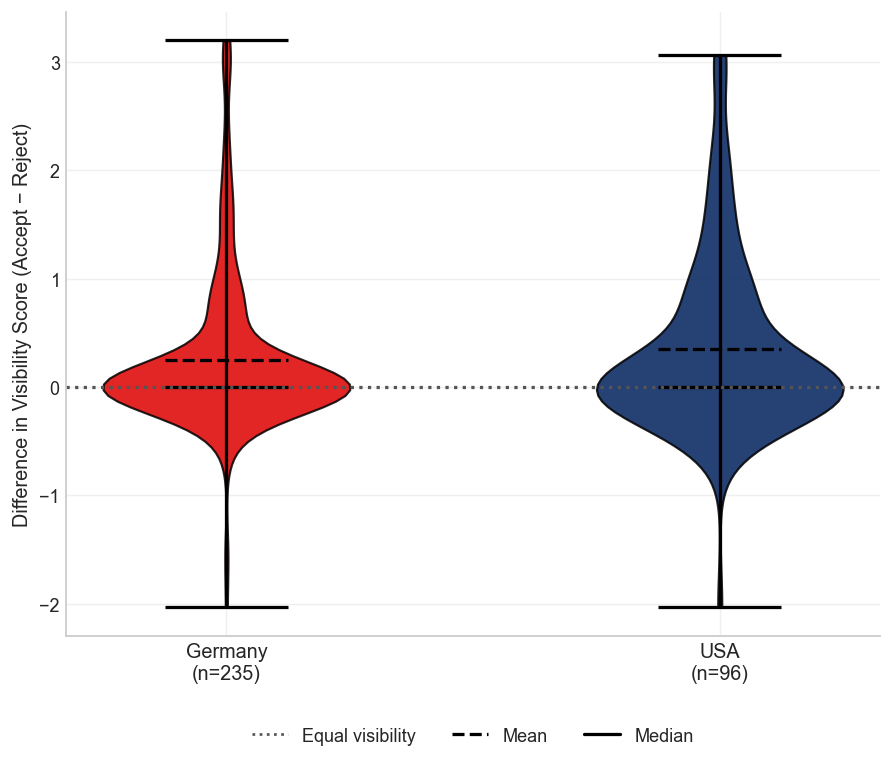

Germany -- n=235  Mean diff=0.25  Median=0.00  | Accept more prominent: 20.9%  | Equally prominent: 75.7%  | Reject more prominent: 2.6%
US -- n=96  Mean diff=0.35  Median=0.00  | Accept more prominent: 30.2%  | Equally prominent: 66.7%  | Reject more prominent: 2.1%


In [15]:
# 1. calculate differences between "accept" and "reject" button prominence
def vis_score_diff(df):
    """
    Calculates the visibility score gap for each website.
    Positive values = Accept button is more visible.
    Negative values = Reject button is more visible.
    """
    df = df.copy()
    
    # get the highest visibility score for 'Accept' (category 1) per site
    acc = df[df['category'] == 1].groupby('website_url')['vis_score'].max()
    # get the highest visibility score for 'Reject' (category 2) per site
    rej = df[df['category'] == 2].groupby('website_url')['vis_score'].max()
    
    # only compare websites that actually have both types of buttons
    common = acc.index.intersection(rej.index)
    
    # return the series of differences (Accept Score minus Reject Score)
    return acc[common] - rej[common]

# process datasets for both regions
de_diff = vis_score_diff(df_buttons_de)
us_diff = vis_score_diff(df_buttons_us)

# initialize the plot
fig, ax = plt.subplots(figsize=(7, 6))

# 2. create the violin plot
# showmeans and showmedians create the internal indicator lines
parts = ax.violinplot(
    [de_diff.dropna().values, us_diff.dropna().values],
    positions=[0, 1], 
    showmeans=True, 
    showmedians=True
)

# color the 'bodies' (the shaded distribution area)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor([COLORS['Germany'], COLORS['USA']][i])
    pc.set_alpha(0.85)
    pc.set_edgecolor('black') # adds a crisp border around the violin
    pc.set_linewidth(1.2)

# style the internal statistical markers
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians'):
    parts[partname].set_color('black')
    parts[partname].set_linewidth(1.8)

# differentiate mean and median visually (Dashed vs Solid)
parts['cmeans'].set_linestyle('--')
parts['cmedians'].set_linestyle('-')

# 3. add the "equal visibility" reference line at y=0
# this helps identify sites with zero difference at a glance
ax.axhline(0, color='#555555', ls=':', lw=1.8)

# 4. academic formatting and cleanup
ax.grid(axis='y', linestyle='-', alpha=0.3) # subtle horizontal grid
ax.set_axisbelow(True) # ensures grid lines stay behind the plot bodies

# remove chart junk (top and right spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# label the axes
ax.set_xticks([0, 1])
ax.set_xticklabels([f'Germany\n(n={len(de_diff):,})', f'USA\n(n={len(us_diff):,})'], fontsize=11)
ax.set_ylabel('Difference in Visibility Score (Accept − Reject)', fontsize=11)

# 5. build custom legend
# manually creating handles ensures the legend matches our custom line styles
equal_line = mlines.Line2D([], [], color='#555555', linestyle=':', lw=1.5, label='Equal visibility')
mean_line = mlines.Line2D([], [], color='black', linestyle='--', lw=1.8, label='Mean')
median_line = mlines.Line2D([], [], color='black', linestyle='-', lw=1.8, label='Median')

# position legend below the plot to avoid overlapping with data
ax.legend(handles=[equal_line, mean_line, median_line], 
          loc='upper center', bbox_to_anchor=(0.5, -0.12), 
          ncol=3, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

# 6. print statistical summary to console for verification
for name, diff in [('Germany', de_diff), ('US', us_diff)]:
    if diff.empty: continue
    
    # calculate percentages using a small 0.5 buffer for "equality"
    pct_equal  = (diff.abs() < 0.5).mean() * 100
    pct_accept = (diff > 0.5).mean() * 100
    pct_reject = (diff < -0.5).mean() * 100
    
    print(f"{name} -- n={len(diff):,}  "
          f"Mean diff={diff.mean():.2f}  Median={diff.median():.2f}  "
          f"| Accept more prominent: {pct_accept:.1f}%  "
          f"| Equally prominent: {pct_equal:.1f}%  "
          f"| Reject more prominent: {pct_reject:.1f}%")

### 6.3 Accept & Reject Button Combinations
For each website, we classify its consent banner into one of three states: **Accept & Reject** (both options present), **Accept Only** (no reject option), or **No Banner / Missing**.

In [16]:
# 1. Create a function to label each website's buttons
def get_button_state(df):
    # Group by website and get the unique categories (1=Accept, 2=Reject)
    cats = df.groupby('website_url')['category'].apply(set)
    
    # Map the categories to your specific labels
    def map_state(c):
        if 1 in c and 2 in c: return 'Accept & Reject'
        if 1 in c: return 'Accept Only'
        return 'Other' # Catch-all for rare edge cases
        
    return cats.apply(map_state)

# 2. Get the states for both countries
de_states = get_button_state(df_buttons_de).rename('Germany')
us_states = get_button_state(df_buttons_us).rename('USA')

# join them together based on the website_url
# pd.concat aligns them by URL. If a site is missing in one dataset, it gets NaN
df_combined = pd.concat([de_states, us_states], axis=1)

# Fill the missing ones
df_combined = df_combined.fillna('No Banner / Missing')

# create the final Pandas comparison table
comparison_table = pd.crosstab(
    df_combined['Germany'], 
    df_combined['USA'],
    margins=True,          # Adds the 'All' totals row/column
    margins_name='Total'
)

# Optional: sort the order so it reads nicely
order = ['Accept & Reject', 'Accept Only', 'No Banner / Missing', 'Total']
comparison_table = comparison_table.reindex(index=order, columns=order, fill_value=0)

comparison_table

USA,Accept & Reject,Accept Only,No Banner / Missing,Total
Germany,,,,
Accept & Reject,85,31,102,235
Accept Only,5,72,40,120
No Banner / Missing,5,4,0,9
Total,96,108,147,381


### 6.4 Top-5 Button Labels per Category
What are the most common button label texts in each category? This reveals regional language and UX patterns in consent design.

In [18]:
for cat_id, cat_name in BUTTON_CATEGORIES.items():
    de_top = (df_buttons_de[df_buttons_de['category'] == cat_id]['normalized']
              .value_counts().head(5).reset_index())
    us_top = (df_buttons_us[df_buttons_us['category'] == cat_id]['normalized']
              .value_counts().head(5).reset_index())
    de_top.columns = ['Germany Label', 'Count']
    us_top.columns = ['USA Label', 'Count']
    table = pd.concat([de_top, us_top], axis=1)
    table.index = range(1, len(table) + 1); table.index.name = 'Rank'
    print(f"\n{cat_name} ({cat_id}):")
    display(table)



Accept (1):


,Germany Label,Count,USA Label,Count
Rank,,,,
1,accept,73,acceptall,35
2,acceptall,69,accept,21
3,consent,38,ok,21
4,acceptallcookies,37,acceptallcookies,15
5,alleakzeptieren,13,acceptcookies,10



Reject (2):


,Germany Label,Count,USA Label,Count
Rank,,,,
1,rejectall,68,rejectall,24
2,reject,34,decline,9
3,donotconsent,10,deny,7
4,alleablehnen,10,donotsellorsharemypersonalinformation,6
5,declineall,10,rejectnonessential,5



Settings (3):


,Germany Label,Count,USA Label,Count
Rank,,,,
1,cookiessettings,40,cookiessettings,27
2,managecookies,35,learnmore→,22
3,manageoptions,29,managepreferences,12
4,managepreferences,14,settings,10
5,customize,13,customisesettings,7



Save (4):


,Germany Label,Count,USA Label,Count
Rank,,,,
1,save,8,save,6
2,allowselectedcookies,6,allowselectedcookies,6
3,savepreferences,5,savepreferences,5
4,allowselection,4,allowselection,3
5,savesettings,3,savesettings,1



Other (5):


,Germany Label,Count,USA Label,Count
Rank,,,,
1,werbefreifur299monat,2,rechazarysuscribirse,2
2,rechazarysuscribirse,2,rechazarypagar,1
3,rechazarypagar,1,werbefreifur299monat,1
4,jemabonne,1,jemabonne,1
5,refuseretsabonner199pouruneexperiencesanspub→,1,refuseretsabonner199pouruneexperiencesanspub→,1
